## 🎭 NLP Market Sentiment Analysis Framework

### ₿ Crypto Fear & Greed Index Fetching

Import of Required Packages

In [116]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

Function for Fetching Daily Crypto Fear & Greed Index

In [ ]:
def get_FNG_index(limit=60, format='json', date_format='cn'):
    """
    Fetch the daily Fear and Greed Index data from the Alternative.me API.

    Parameters:
    limit (int): The number of entries to return (Default to 60, which returns the latest 60 days of data; set to 0 for all available data).
    format (str): The format of the response (Default to 'json').
    date_format (str): The format of the date in the response (Default to 'cn' for Chinese format; 'us', 'kr', and 'world' also available).

    Returns:
    pd.DataFrame: A date-indexed DataFrame containing the Fear and Greed Index values and their classifications.

    Raises:
    Exception: If the API request fails or returns an error status code.
    """

    url = "https://api.alternative.me/fng/"
    params = {
        "limit": limit,
        "format": format,
        "date_format": date_format
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()

        indices = pd.DataFrame(data['data'])
        indices = indices.sort_values('timestamp', ascending=True).reset_index(drop=True).set_index('timestamp')
        indices = indices[['value', 'value_classification']]

        return indices
    else:
        raise Exception(f"API request failed with status code {response.status_code}")

Function for plotting the Fear & Greed Index

In [118]:
def plot_FNG_index(indices: pd.DataFrame):
    """
    Plot the Fear and Greed Index values and their classifications.

    Parameters:
    indices (pd.DataFrame): A DataFrame containing the Fear and Greed Index values and their classifications.
    """

    plt.figure(figsize=(14, 7))

    plt.plot(indices.index, indices['value'], label='Fear & Greed Index', color='blue')

    plt.title('Fear & Greed Index Over Time')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

Fear & Greed Index of the Past Two Months

In [119]:
fng_index = get_FNG_index()

In [120]:
fng_index.head()

,value,value_classification
timestamp,,
2025-05-19,74,Greed
2025-05-20,71,Greed
2025-05-21,70,Greed
2025-05-22,72,Greed
2025-05-23,78,Extreme Greed


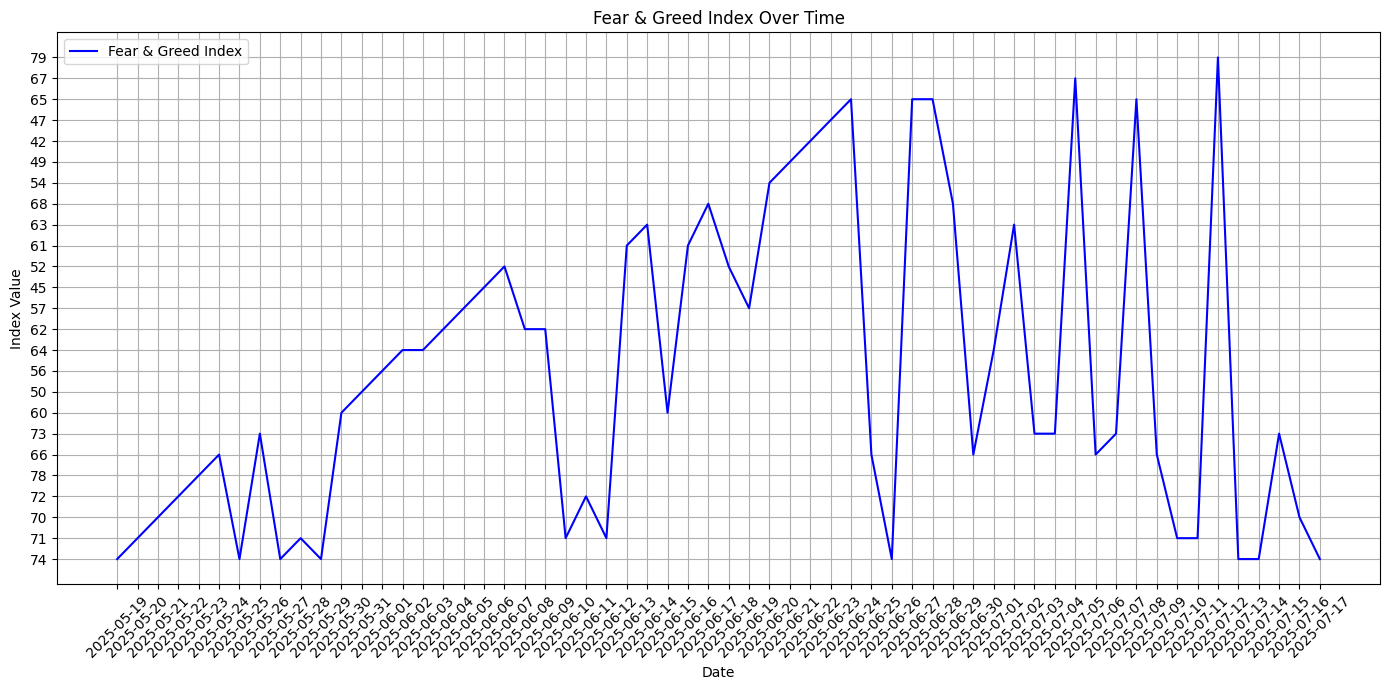

In [121]:
plot_FNG_index(fng_index)

### 🌐 FinBERT Financial Market Sentiment Analysis Model

Import of Required Packages

In [122]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

Functions for Loading the FinBERT Model and Predicting Text(s)' Sentiment(s) using FinBERT

In [123]:
def FINBERT_model_create():
    """
    Create and return the FINBERT model and tokenizer.

    Returns:
    tokenizer (AutoTokenizer): The tokenizer for the FINBERT model.
    model (AutoModelForSequenceClassification): The FINBERT model for sequence classification.
    """

    # Load the tokenizer and model from the pre-trained FINBERT model
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

    return tokenizer, model

In [124]:
def FINBERT_predict(tokenizer, model, texts: list[str] | str):
    """
    Predict sentiment using the FINBERT model.

    Parameters:
    tokenizer: The tokenizer for the FINBERT model.
    model: The FINBERT model.
    text (list[str] | str): The input text(s) to analyze.

    Returns:
    int: The predicted sentiment label.
    """

    if isinstance(texts, str):
        texts = [texts]

    predictions = {}
    tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
    
    for t in texts:
        with torch.no_grad():
            input_sequence = tokenizer(t, return_tensors="pt", **tokenizer_kwargs)
            logits = model(**input_sequence).logits
            scores = {
                k: v
                for k, v in zip(
                    model.config.id2label.values(),
                    scipy.special.softmax(logits.numpy().squeeze()),
                )
            }
        sentimentFinbert = max(scores, key=scores.get)
        sentiment_prob = round(float(max(scores.values())), 2)

        predictions[t] = (sentimentFinbert, sentiment_prob)

    return predictions

Financial PhraseBank Dataset

In [125]:
sentiment_data = pd.read_csv('sentiment-data-kaggle.csv', # Replace with any CSV file containing sentiment data
                   encoding='unicode_escape',
                   names=['Sentiment', 'Text'])

In [126]:
sentiment_data.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


Sentiment Analysis of Financial PhraseBank Data

In [127]:
# Create the FINBERT model and tokenizer
tokenizer, model = FINBERT_model_create()

In [128]:
# Example texts for prediction
texts = sentiment_data['Text'].tolist()[:4]

In [129]:
predictions = FINBERT_predict(tokenizer, model, texts)

In [130]:
predictions

{'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .': ('neutral',
  0.89),
 'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .': ('neutral',
  0.53),
 'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .': ('negative',
  0.97),
 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .': ('positive',
  0.95)}